In [5]:
from pathlib import Path
import re
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Path to your local copy
# DATA_PATH = Path("data/raw/TinyStories/TinyStories-train.txt")
DATA_PATH = Path("..") / "data" / "raw" / "TinyStories" / "TinyStoriesV2-GPT4-train.txt"


# Regular expression to recognize the <|endoftext|> delimiter
DELIM_RE = re.compile(r"\s*<\|endoftext\|\>\s*", flags=re.IGNORECASE)


In [3]:
# Rolling through the huge .txt file without loading it all into memory (doing 1MB at a time)

def stream_stories(path: Path, chunk_size: int = 1024 * 1024):
    """
    Yield one story at a time by splitting on <|endoftext|>.
    Reads in small chunks so we never hold the whole file in memory.
    """
    buf = ""
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            buf += chunk
            parts = DELIM_RE.split(buf)
            # all but the last are complete stories
            for s in parts[:-1]:
                s = s.strip()
                if s:
                    yield s
            buf = parts[-1]  # keep the tail for the next read
        # flush the remainder
        tail = buf.strip()
        if tail:
            yield tail


In [3]:
# Quick sanity checks through first 3 stories

for i, story in zip(range(3), stream_stories(DATA_PATH)):
    print(f"--- Story {i} ---")
    print(story[:400], "...\n")


--- Story 0 ---
Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  
He said, “Wow, that is a really amazing vase! Can I buy it?” 
The shopkeeper smiled and said, “Of course yo ...

--- Story 1 ---
Once upon a time, there was a reliable otter named Ollie. He lived in a river with his family. They all loved to play and swim together.
One day, Ollie's mom said, "Ollie, hurry and get some fish for dinner!" Ollie swam fast to catch fish. He saw his friend, the duck. "Hi, Ollie!" said the duck. "Hi, duck!" said Ollie. "I need to hurry and catch fish for my family."
While Ollie was catching fish,  ...

--- Story 2 ---
One day, a little boy named Tim went to the park. He saw a big tiger. The tiger was not mean, but very easy to play with. Tim and the tiger 

In [4]:
# Counting non-empty stories exist between <|endoftext|> markers in the file

def count_stories_with_byte_progress(path: Path, chunk_size: int = 1024 * 1024):
    total_bytes = path.stat().st_size
    count = 0
    buf = ""
    with path.open("r", encoding="utf-8", errors="ignore") as f, \
         tqdm(total=total_bytes, unit="B", unit_scale=True, desc="Reading file") as pbar:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            buf += chunk
            pbar.update(len(chunk))             # <- updates smoothly each chunk
            parts = DELIM_RE.split(buf)
            count += sum(1 for s in parts[:-1] if s.strip())
            buf = parts[-1]
        if buf.strip():
            count += 1
    return count

story_count = count_stories_with_byte_progress(DATA_PATH)
print(f"Total stories: {story_count:,}")

Reading file:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Total stories: 2,717,495


In [5]:
# Counting the amount of <|endoftext|> markers in the file 

def count_delims(path: Path, needle="<|endoftext|>"):
    total = 0
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), ""):
            total += chunk.lower().count(needle)
    return total

raw_delims = count_delims(DATA_PATH)
print(f"Raw <|endoftext|> markers: {raw_delims:,}")


Raw <|endoftext|> markers: 2,717,660


# Analyzing first words of stories

In [6]:
# strip quotes/punctuation then grab the first alphabetical word
FIRST_WORD_RE = re.compile(r"^[\s\"'\-–—\(\[\{]*([A-Za-z]+)")

def first_word(text: str) -> str | None:
    m = FIRST_WORD_RE.match(text)
    if not m:
        return None
    return m.group(1).lower()


In [7]:
first_word_counts = Counter()
for story in tqdm(stream_stories(DATA_PATH), desc="Counting first words"):
    w = first_word(story)
    if w:
        first_word_counts[w] += 1

len(first_word_counts), sum(first_word_counts.values())


Counting first words: 0it [00:00, ?it/s]

(2317, 2717457)

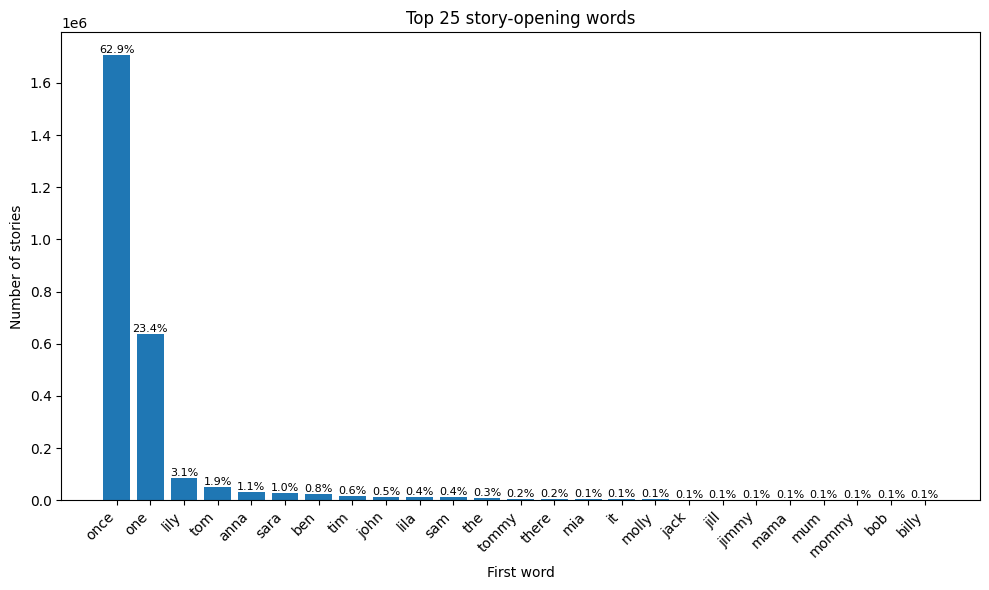

In [8]:
TOP_N = 25  # number of bars to plot in First Word barplot
top_items = first_word_counts.most_common(TOP_N)

words  = [w for w, c in top_items]
counts = [c for w, c in top_items]

total_stories = sum(first_word_counts.values())
percentages = [c / total_stories * 100 for c in counts]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(words)), counts)
plt.xticks(range(len(words)), words, rotation=45, ha="right")
plt.title(f"Top {TOP_N} story-opening words")
plt.xlabel("First word")
plt.ylabel("Number of stories")

# annotate each bar with its percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


# Analyzing number of words per story

In [9]:
word_counts = []
for story in tqdm(stream_stories(DATA_PATH), desc="Counting words per story"):
    # simple split on whitespace; fine for TinyStories
    n_words = len(story.split())
    word_counts.append(n_words)

print(f"Processed {len(word_counts):,} stories.")
print(f"Shortest: {min(word_counts)} words, longest: {max(word_counts)} words")

Counting words per story: 0it [00:00, ?it/s]

Processed 2,717,495 stories.
Shortest: 1 words, longest: 963 words


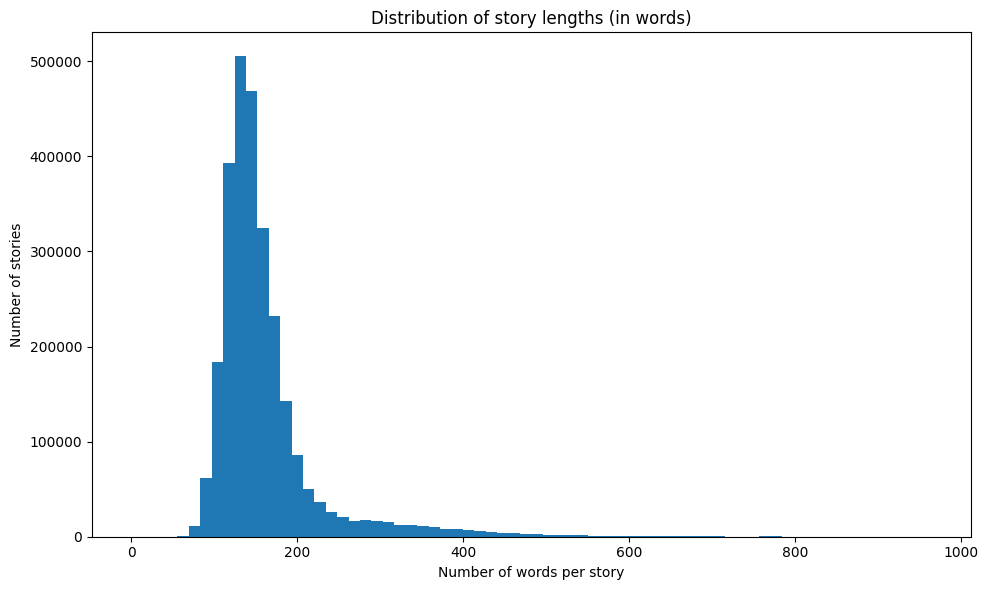

In [10]:
plt.figure(figsize=(10,6))
plt.hist(word_counts, bins=70)  # specify how many bins
plt.title("Distribution of story lengths (in words)")
plt.xlabel("Number of words per story")
plt.ylabel("Number of stories")
plt.tight_layout()
plt.show()


# Analyzing Unique Words

In [1]:
# Simple word tokenizer: lowercase + split on word boundaries
def tokenize_words(text: str):
    # \b\w+\b = sequences of letters/digits/underscore between word boundaries
    return re.findall(r"\b\w+\b", text.lower())

from collections import Counter

global_word_counter = Counter()   # counts over *all* stories
unique_counts_per_story = []      # one integer per story (unique words in that story)
stories_seen = 0


In [6]:
from tqdm.notebook import tqdm

for story in tqdm(stream_stories(DATA_PATH), desc="Scanning stories"):
    tokens = tokenize_words(story)
    if not tokens:
        continue

    # update global vocab counts
    global_word_counter.update(tokens)

    # unique words in *this* story
    unique_counts_per_story.append(len(set(tokens)))
    stories_seen += 1

stories_seen, len(global_word_counter)


Scanning stories: 0it [00:00, ?it/s]

(2717495, 37064)

Total unique words across dataset: 37,064
Stories seen: 2,717,495
Mean unique words/story: 81.11
Median: 77.00
Min: 1, Max: 353

Top 20 most frequent words:
       the : 26757941
       and : 19916483
         a : 15319880
        to : 14926075
       was : 10593660
      they : 8600329
        he : 8203155
        it : 7100901
       she : 6053230
      said : 4370528
      with : 4243887
       day : 4217557
       tim : 4216992
       his : 4166763
       her : 4153604
        in : 4050442
       you : 3678947
       big : 3440332
       but : 2973980
       had : 2875952


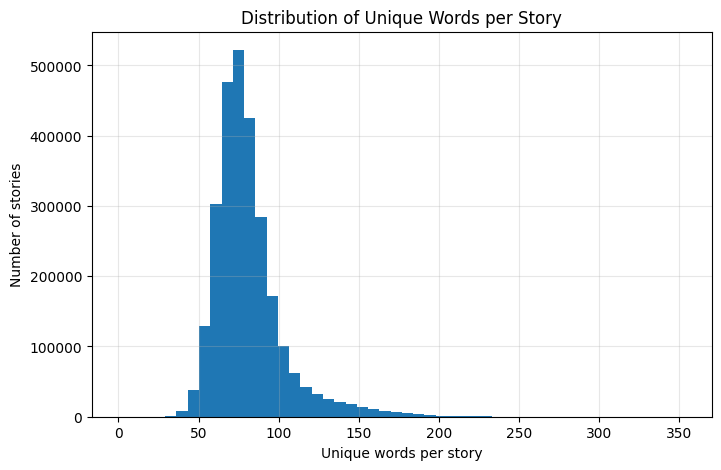

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Total unique words in entire dataset
total_unique_words = len(global_word_counter)
print(f"Total unique words across dataset: {total_unique_words:,}")

# 2) Summary stats for per-story unique word counts
unique_counts = np.array(unique_counts_per_story)
print(f"Stories seen: {stories_seen:,}")
print(f"Mean unique words/story: {unique_counts.mean():.2f}")
print(f"Median: {np.median(unique_counts):.2f}")
print(f"Min: {unique_counts.min()}, Max: {unique_counts.max()}")

# 3) Top 20 most frequent words (just for fun)
print("\nTop 20 most frequent words:")
for word, freq in global_word_counter.most_common(20):
    print(f"{word:>10} : {freq}")

# 4) Histogram of unique words per story
plt.figure(figsize=(8,5))
plt.hist(unique_counts, bins=50)
plt.title("Distribution of Unique Words per Story")
plt.xlabel("Unique words per story")
plt.ylabel("Number of stories")
plt.grid(alpha=0.3)
plt.show()
